In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss

In [2]:
df=pd.read_csv('Data/df_bp9.csv')

/tmp/ipykernel_13382/623349023.py:1: DtypeWarning: Columns (13,14,15,19,85,87,159,198) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Data/df_bp9.csv')


In [3]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1980) & (df.season<=2018) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2019) & (df.season<=2020)]
df_test = df[df.season>=2021]
df_test_val = df[df.season>=2019]
df.shape

(96215, 1235)

In [4]:
hv_mean = df_train.home_victory.mean()
hv_mean

0.5391635426429241

In [5]:
target = 'home_victory'

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [6]:
def try_features(feat_set, max_depth=2):
    target = 'home_victory'
    X_train = df_train.loc[:,feat_set]
    X_valid = df_valid.loc[:,feat_set]
    X_test = df_test.loc[:,feat_set]



    lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=max_depth)
    lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50)])
    
    preds_lgbm_test = lgbm1.predict_proba(X_test)[:,1]
    ll_test = log_loss(y_test, preds_lgbm_test)

    print(f'\nVegas probs: {log_loss(y_test,df_test.implied_prob_h_mid)} on test')
    print(f'model probs: {ll_test} on test')

    print(f'\nDifference: {ll_test - log_loss(y_test,df_test.implied_prob_h_mid)} on test')

    sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
    sv_lgbm = pd.DataFrame(sv_lgbm)
    sv_lgbm.columns = list(X_test.columns)+['Intercept']
    sv_vec = sv_lgbm.abs().mean().sort_values(ascending=False)
    print('\nAvg Shap Vals')
    
    print(sv_vec)
    out_dict={}
    out_dict['ll_test'] = ll_test
    out_dict['model'] = lgbm1
    out_dict['shap_val_avgs'] = sv_vec
    out_dict['preds_test'] = preds_lgbm_test
    return(out_dict)

In [7]:
features0 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v']

In [8]:
d0 = try_features(features0)

[LightGBM] [Info] Number of positive: 46023, number of negative: 39337
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 85360, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539164 -> initscore=0.156976
[LightGBM] [Info] Start training from score 0.156976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[603]	valid_0's binary_logloss: 0.672806

Vegas probs: 0.6675629431340582 on test
model probs: 0.6714934504802158 on test

Difference: 0.00393050734615763 on test

Avg Shap Vals
Intercept               0.159327
Strt_SO_perc_10_h       0.079810
Strt_SO_perc_10_v       0.079673
OBP_162_v               0.062744
Strt_WHIP_35_v          0.053249
Strt_WHIP_35_h          0.052227
OBP_162_h               0.049028


In [9]:
f_lineup_a = [
            'lineup9_OBP_162_h','lineup9_OBP_162_v',
            'lineup9_SLG_162_h','lineup9_SLG_162_v',
]

features1 = features0 + f_lineup_a

In [10]:
d1 = try_features(features1)

[LightGBM] [Info] Number of positive: 46023, number of negative: 39337
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 85360, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539164 -> initscore=0.156976
[LightGBM] [Info] Start training from score 0.156976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[638]	valid_0's binary_logloss: 0.672435

Vegas probs: 0.6675629431340582 on test
model probs: 0.6705352971803024 on test

Difference: 0.0029723540462441855 on test

Avg Shap Vals
Intercept               0.159555
Strt_SO_perc_10_v       0.078905
Strt_SO_perc_10_h       0.076724
Strt_WHIP_35_h          0.049814
Strt_WHIP_35_v          0.049799
lineup9_SLG_162_v       0.046246
OBP_162_v               0.0461

In [11]:
discreps_lv1 = (d1['preds_test']-df_test.implied_prob_h_mid).to_numpy() # With lineup features

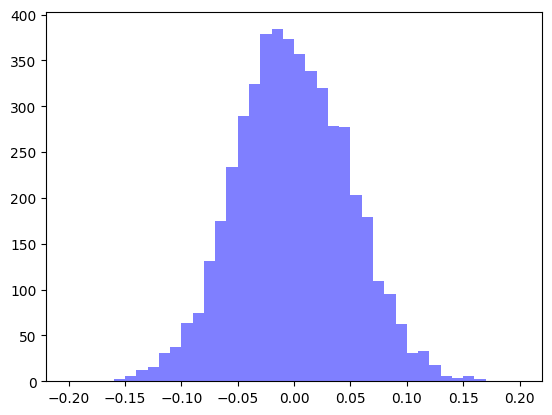

In [12]:
plt.hist(discreps_lv1, bins=np.linspace(-.2,.2,41), alpha=.5, color='blue');